In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths
DATA_PATH = "/content/drive/MyDrive/AI_MUSAS/Modelo_3_Afectivo/Preposesamiento_Audios/Class_M3"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val")
TEST_PATH = os.path.join(DATA_PATH, "test")
# Define image size
IM_SIZE = (224, 224)
# Define batch size
BATCH_SIZE = 32

In [ ]:
# Define Class
csv_file = '/content/drive/MyDrive/AI_MUSAS/Modelo_3_Afectivo/Csv_Final/Cuadrantes.csv'
df = pd.read_csv(csv_file)
classes = df['cuadrante'].unique().tolist()

In [ ]:
# Short names for classes
classesShort = [str(i) + class_label[:5] for i, class_label in enumerate(classes)]
print(classesShort)

['0Calma', '1Caoti', '2Monot', '3Vibra']


In [ ]:
# Mapping file names to labels
file_label_map = dict(zip(df['name'], df['cuadrante']))

In [ ]:
# Create data generators with labels and apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classesShort,
    shuffle=True,
    interpolation='nearest',
    seed=42
)

train_batches.class_indices = {label: i for i, label in enumerate(train_batches.class_indices)}

valid_batches = valid_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classesShort,
    shuffle=False,
    interpolation='nearest',
    seed=42
)

valid_batches.class_indices = {label: i for i, label in enumerate(valid_batches.class_indices)}

test_batches = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IM_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classesShort,
    shuffle=False,
    interpolation='nearest',
    seed=42
)

test_batches.class_indices = {label: i for i, label in enumerate(test_batches.class_indices)}

Found 1871 images belonging to 4 classes.
Found 374 images belonging to 4 classes.
Found 251 images belonging to 4 classes.


In [ ]:
# Create EfficientNet model
def efficientnet_model(input_shape, out_neurons, prefix=""):
    input_tensor = tf.keras.layers.Input(shape=input_shape, name=prefix+"input")
    base_model = EfficientNetB0(include_top=False, input_tensor=input_tensor)

    x = tf.keras.layers.GlobalAveragePooling2D(name=prefix+"global_avg_pool")(base_model.output)
    attention = Attention(name=prefix+"attention_1")([x, x])
    x = tf.keras.layers.multiply([x, attention], name=prefix+"multiply_1")
    x = tf.keras.layers.Dense(256, activation='relu', name=prefix+"dense_1")(x)
    x = tf.keras.layers.Dropout(0.7, name=prefix+"dropout_1")(x)

    attention = Attention(name=prefix+"attention_2")([x, x])
    x = tf.keras.layers.multiply([x, attention], name=prefix+"multiply_2")
    x = tf.keras.layers.Dense(256, activation='relu', name=prefix+"dense_2")(x)
    x = tf.keras.layers.Dropout(0.7, name=prefix+"dropout_2")(x)

    output = tf.keras.layers.Dense(out_neurons, activation='softmax', name=prefix+"output")(x)
    return tf.keras.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
# Create VGG16 model
def vgg16_model(input_shape, out_neurons, prefix=""):
    input_tensor = tf.keras.layers.Input(shape=input_shape, name=prefix+"input")
    base_model = VGG16(include_top=False, input_tensor=input_tensor)

    x = tf.keras.layers.GlobalAveragePooling2D(name=prefix+"global_avg_pool")(base_model.output)
    x = tf.keras.layers.Dense(256, activation='relu', name=prefix+"dense_1")(x)
    x = tf.keras.layers.Dropout(0.7, name=prefix+"dropout_1")(x)
    x = tf.keras.layers.Dense(256, activation='relu', name=prefix+"dense_2")(x)
    x = tf.keras.layers.Dropout(0.7, name=prefix+"dropout_2")(x)

    output = tf.keras.layers.Dense(out_neurons, activation='softmax', name=prefix+"output")(x)
    return tf.keras.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
# Create separate models based on EfficientNet and VGG16
input_shape = (224, 224, 3)

efficientnet_model_a = efficientnet_model(input_shape, len(classesShort), prefix="efficientnet_a_")
vgg16_model_a = vgg16_model(input_shape, len(classesShort), prefix="vgg16_a_")

In [ ]:
# Concatenate the outputs of both models
merged = Concatenate(name="concatenate_models")([efficientnet_model_a.output, vgg16_model_a.output])

In [ ]:
# Final output layer
output = Dense(units=len(classesShort), activation='softmax', name="final_output")(merged)

In [ ]:
# Create the final model
final_model = Model(inputs=[efficientnet_model_a.input, vgg16_model_a.input], outputs=output)

In [ ]:
# Compile the final model
final_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display the model summary
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 efficientnet_a_input (Inpu  [(None, 224, 224, 3)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['efficientnet_a_input[0][0]']
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                            

In [ ]:
# Define ModelCheckpoint to save weights
checkpoint_path = '/content/drive/MyDrive/AI_MUSAS/Modelo_3_Afectivo/Model/Weights/Version_Final/FinalModelWeights.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

In [ ]:
# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [ ]:
# Train the final model with EarlyStopping
history = final_model.fit(
    [train_batches.next()[0], train_batches.next()[0]],
    train_batches.next()[1],
    validation_data=([valid_batches.next()[0], valid_batches.next()[0]], valid_batches.next()[1]),
    epochs=250,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/250
1/1 [==============================] - 1s 694ms/step - loss: 1.4565 - accuracy: 0.1562 - val_loss: 1.5235 - val_accuracy: 0.1875
Epoch 2/250
1/1 [==============================] - 0s 354ms/step - loss: 1.4566 - accuracy: 0.1875 - val_loss: 1.5305 - val_accuracy: 0.1875
Epoch 3/250
1/1 [==============================] - 0s 347ms/step - loss: 1.4953 - accuracy: 0.2188 - val_loss: 1.5691 - val_accuracy: 0.1562
Epoch 4/250
1/1 [==============================] - 0s 349ms/step - loss: 1.4182 - accuracy: 0.1562 - val_loss: 1.6012 - val_accuracy: 0.1562
Epoch 5/250
1/1 [==============================] - 0s 354ms/step - loss: 1.4342 - accuracy: 0.1875 - val_loss: 1.6261 - val_accuracy: 0.1562
Epoch 6/250
1/1 [==============================] - 0s 344ms/step - loss: 1.3538 - accuracy: 0.3438 - val_loss: 1.6451 - val_accuracy: 0.1562
Epoch 7/250
1/1 [==============================] - 0s 347ms/step - loss: 1.4134 - accuracy: 0.2812 - val_loss: 1.6677 - val_accuracy: 0.0312
Epoch 8/250
1

In [ ]:
final_accuracy_train = history.history['accuracy'][-1]
final_accuracy_val = history.history['val_accuracy'][-1]

print(f'Accuracy on training set: {final_accuracy_train}')
print(f'Accuracy on validation set: {final_accuracy_val}')

Accuracy on training set: 0.71875
Accuracy on validation set: 0.0625


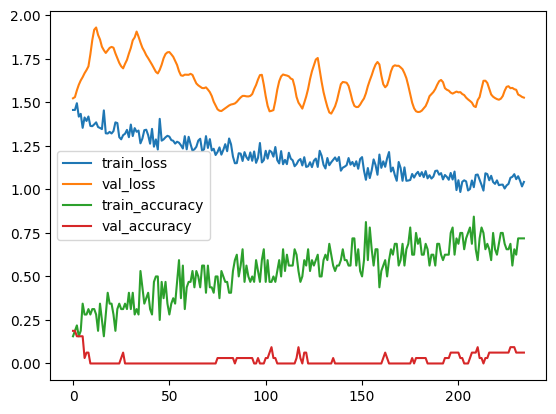

In [ ]:
# Visualize the training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()